# Machine Learning - Trabalho prático 1

## Análise exploratória
Para analisar os dados, iremos utilizar algumas bibliotecas:

In [1]:
import math

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display

from types import SimpleNamespace as Object

### Sumário dos dados
Desejamos conhecer a dimensão e o tipo dos dados:

In [2]:
data = pd.read_csv('koi_data.csv')

print('Número de linhas: {}'.format(data.shape[0]))
print('Número de colunas: {}'.format(data.shape[1]))
print('Dados faltantes: {}'.format(data.isnull().sum().sum()))

print('\nDataframe:')
data.info()

print('\nAmostra:')
with pd.option_context('max_columns', 5): # Limita o numero de cols mostradas
    display(data.head(5))

Número de linhas: 5202
Número de colunas: 43
Dados faltantes: 0

Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 43 columns):
kepoi_name          5202 non-null object
koi_disposition     5202 non-null object
koi_period          5202 non-null float64
koi_impact          5202 non-null float64
koi_duration        5202 non-null float64
koi_depth           5202 non-null float64
koi_ror             5202 non-null float64
koi_srho            5202 non-null float64
koi_prad            5202 non-null float64
koi_sma             5202 non-null float64
koi_incl            5202 non-null float64
koi_teq             5202 non-null float64
koi_insol           5202 non-null float64
koi_dor             5202 non-null float64
koi_max_sngle_ev    5202 non-null float64
koi_max_mult_ev     5202 non-null float64
koi_model_snr       5202 non-null float64
koi_steff           5202 non-null float64
koi_slogg           5202 non-null float64
koi_smet            5

,kepoi_name,koi_disposition,...,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,...,0.310,0.320
1,K00752.02,CONFIRMED,...,0.120,0.500
2,K00754.01,FALSE POSITIVE,...,0.099,0.276
3,K00755.01,CONFIRMED,...,0.020,0.070
4,K00114.01,FALSE POSITIVE,...,7.713,8.948


## Features
O *target* é a coluna `koi_disposition` que identifica se um corpo é de fato um exoplaneta.  
A coluna `kepoi_name` representa o nome de cada corpo, e portanto não constitui uma *feature*.

In [3]:
target = 'koi_disposition'

data = data.drop('kepoi_name', axis = 1)

features = list(data.columns)
features.remove(target)

### Target
Sendo o *target* um dado categórico, é necessário codificá-lo.  
Como existem apenas dois valores, uma codificação binária é suficiente.

In [4]:
print('Target: ' + target)

values = data[target].unique()

assert(len(values) == 2)

encoding = {
  values[0]: 0,
  values[1]: 1
}

display(pd.DataFrame.from_dict(encoding, orient = 'index', columns = ['encoding']))
print()

data[target] = data[target].map(encoding)

display(
  (data[target].value_counts() * 100 / len(data))
    .round(2)
    .to_frame(target +' (%)')
    .T
)

Target: koi_disposition


,encoding
CONFIRMED,0
FALSE POSITIVE,1


,1,0
koi_disposition (%),59.55,40.45


### Distribuição dos dados

Features:


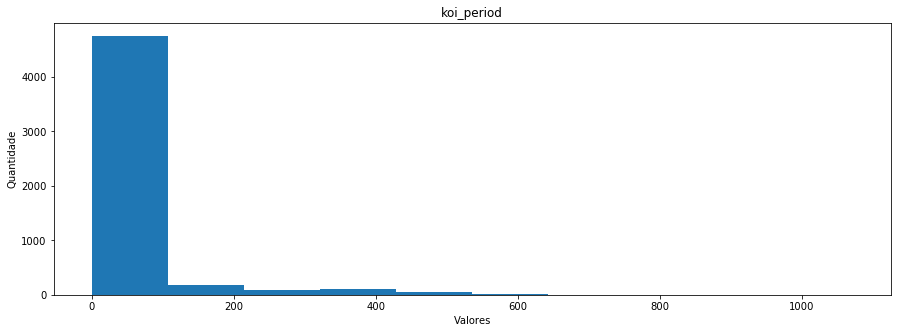

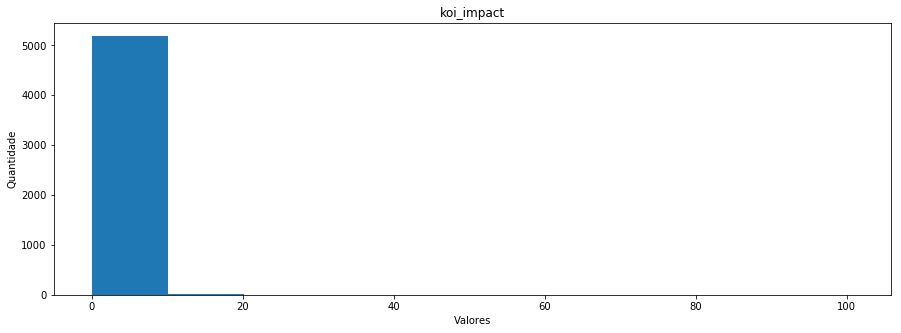

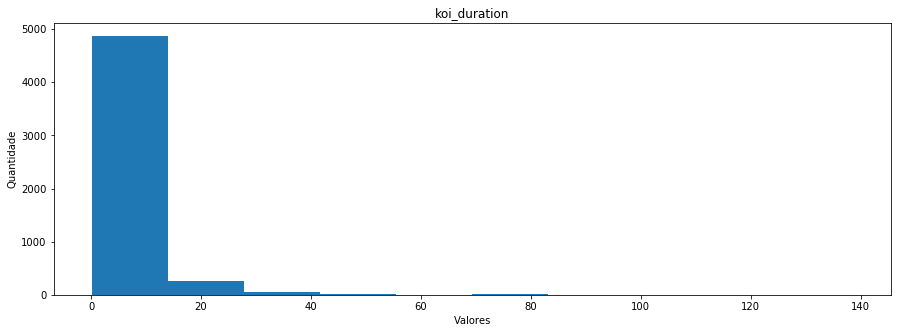

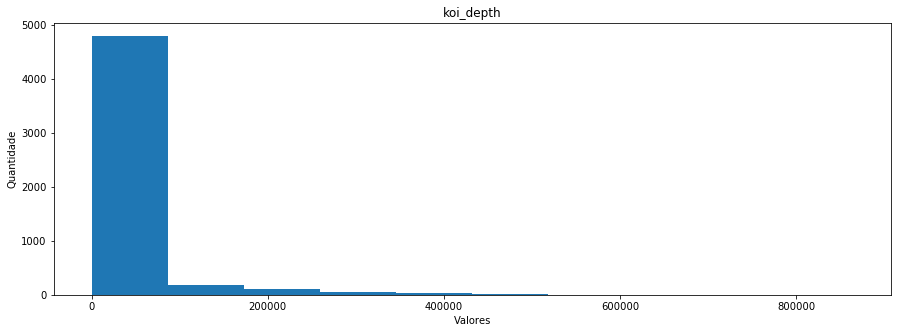

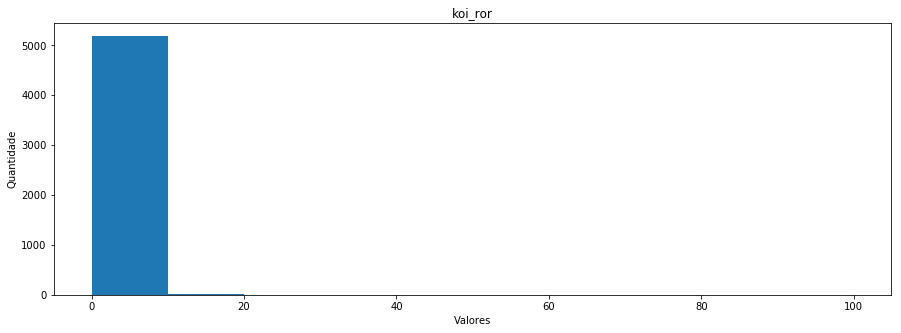

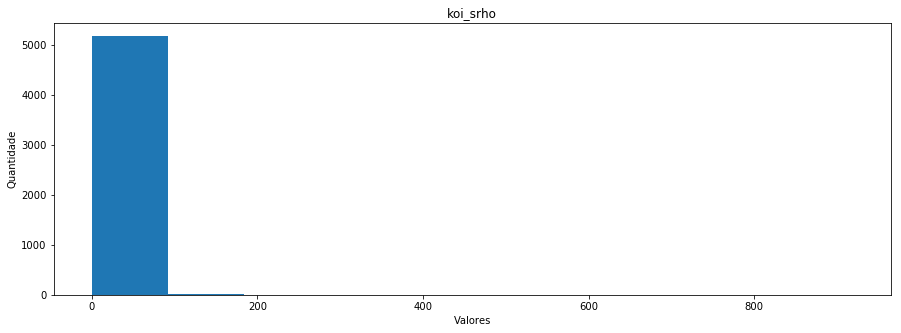

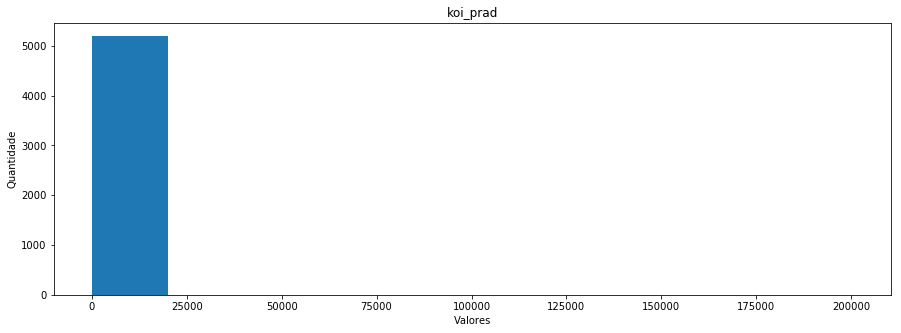

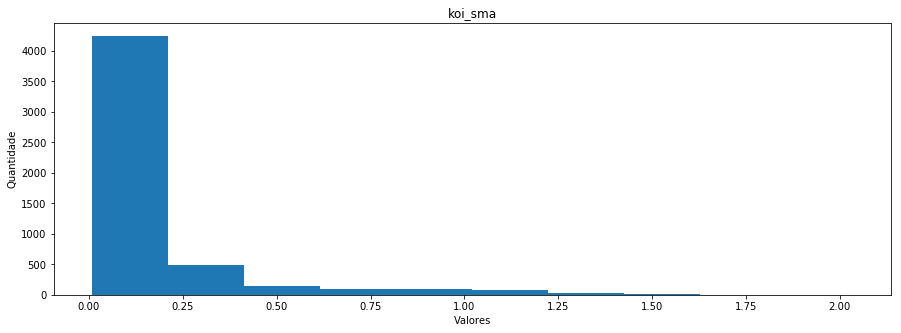

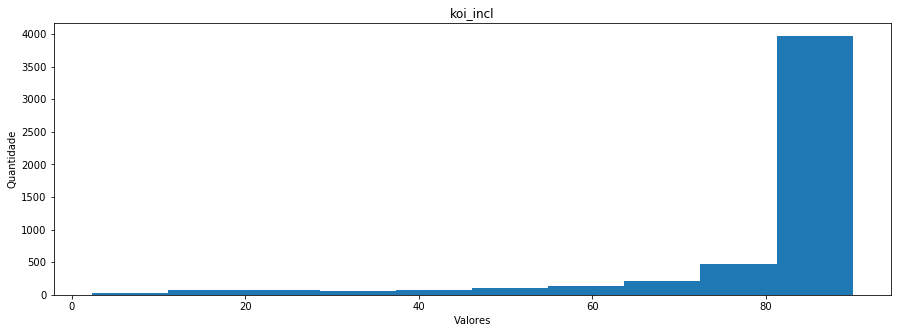

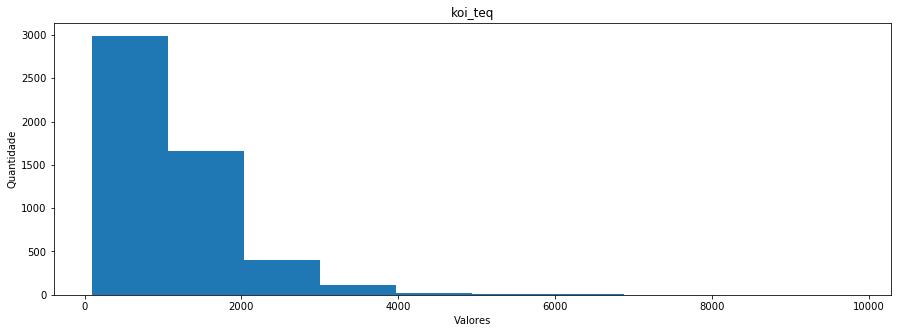

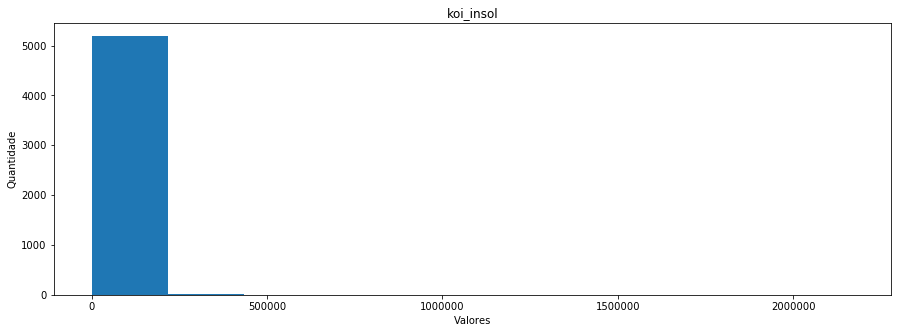

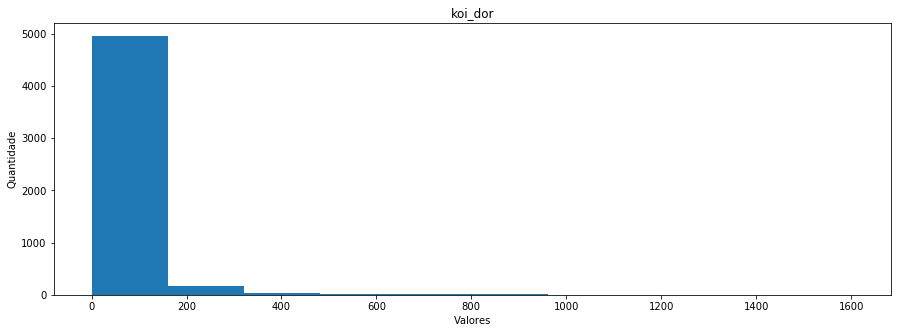

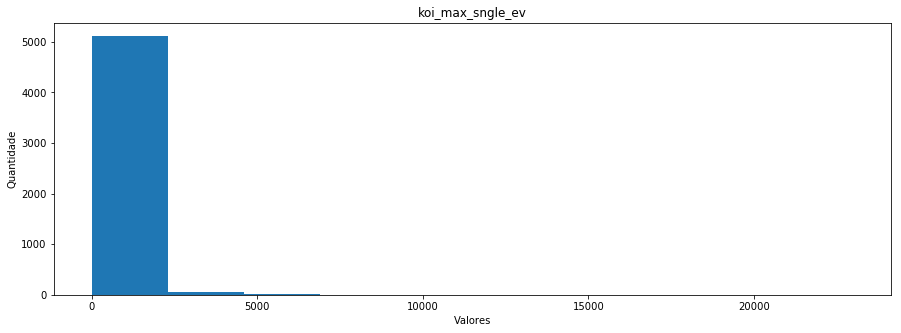

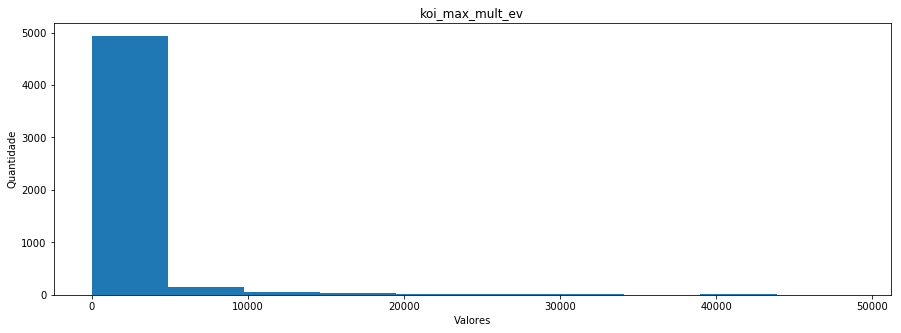

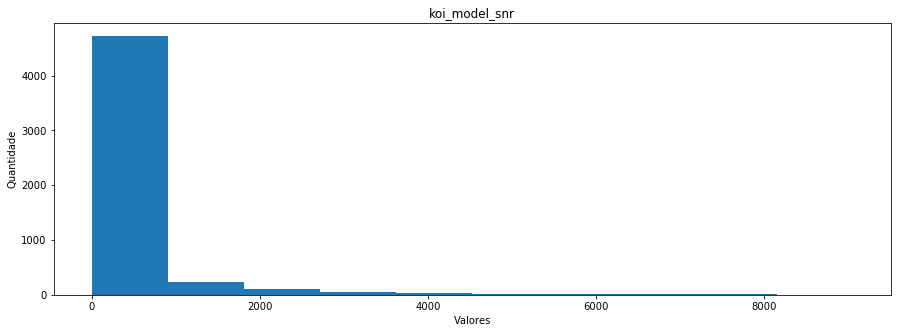

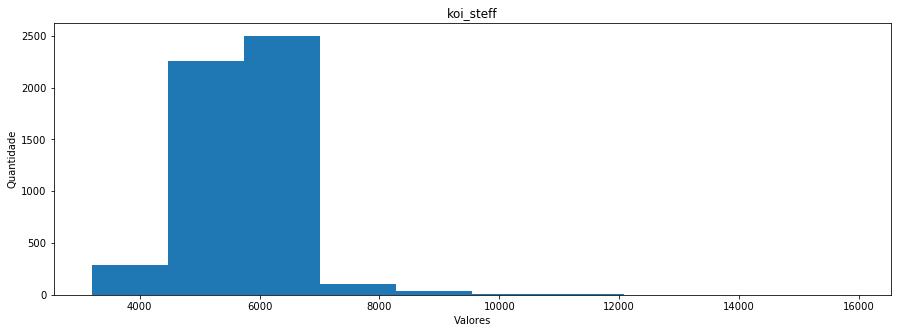

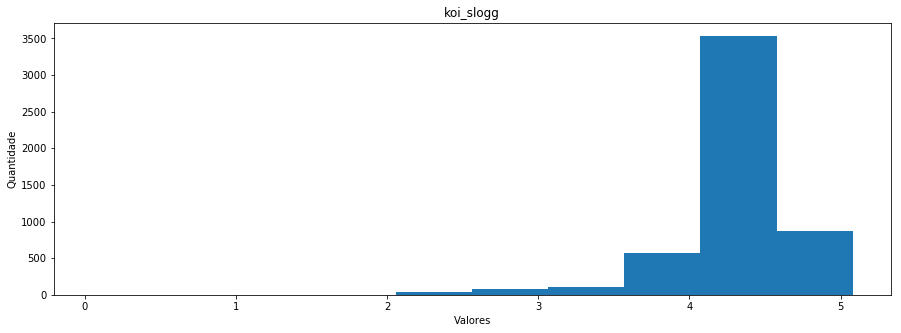

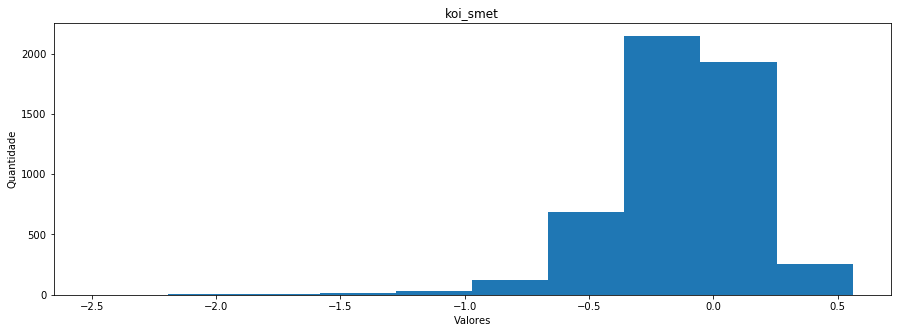

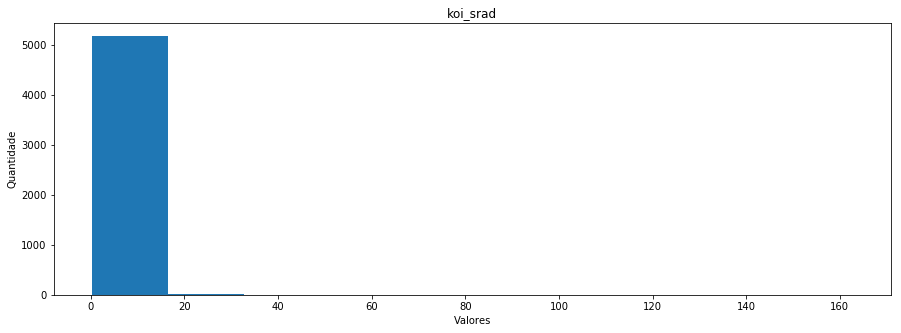

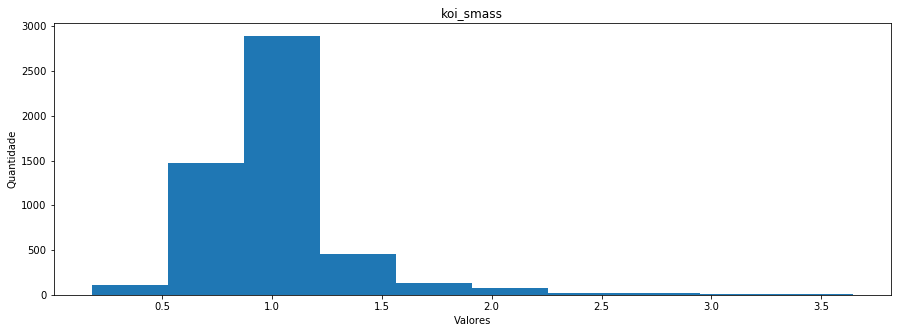

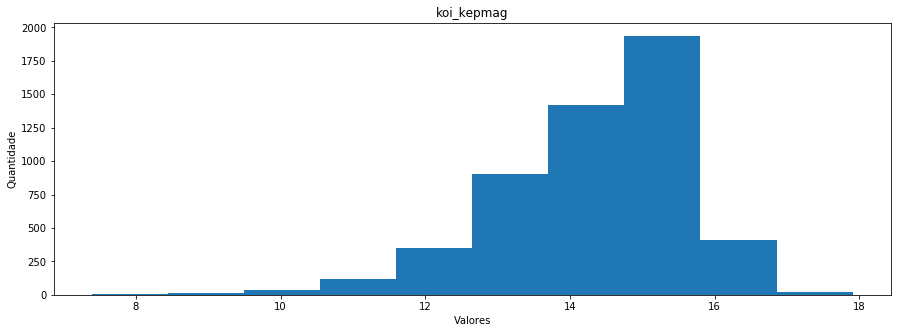

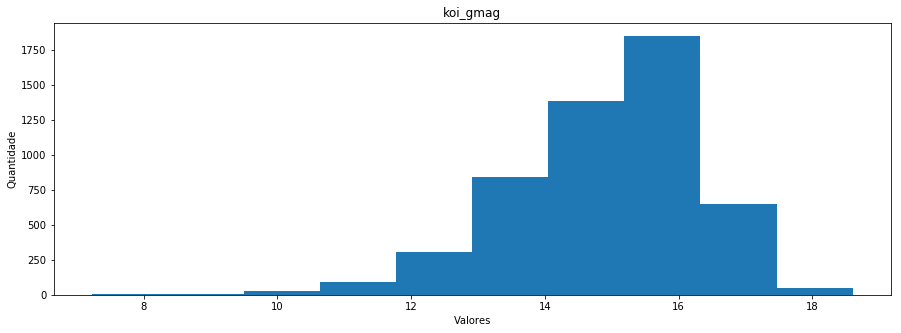

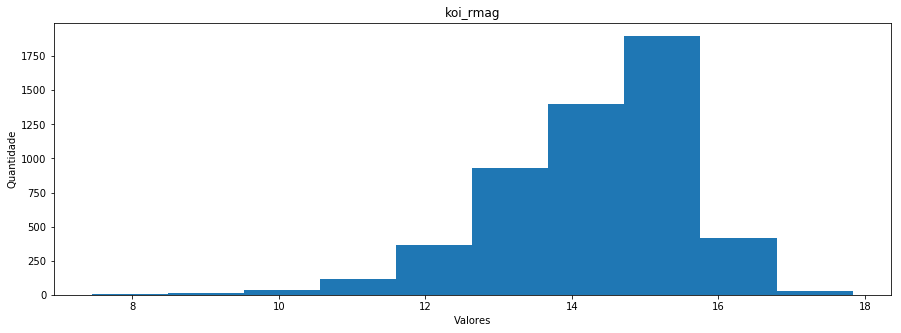

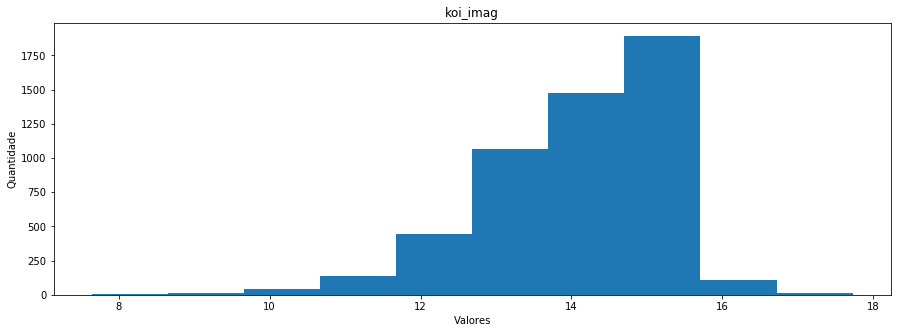

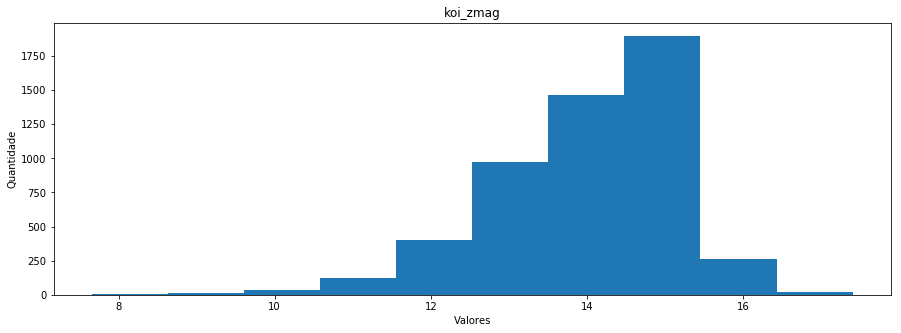

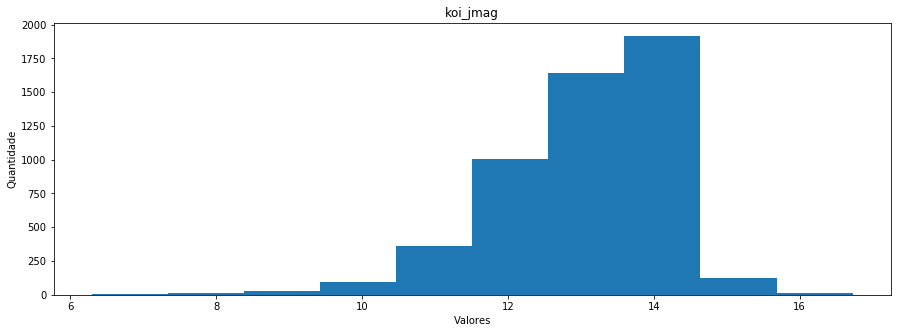

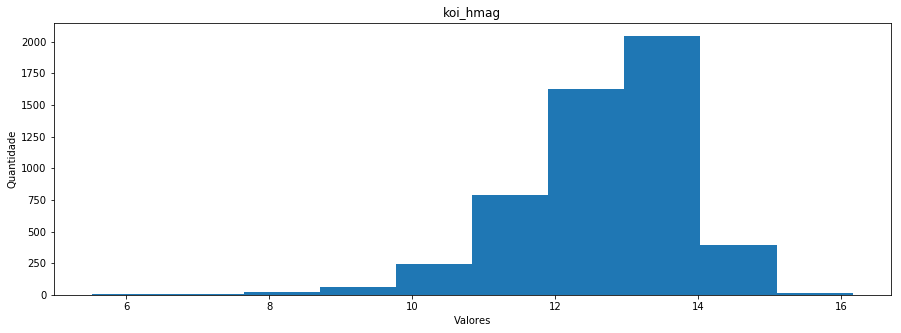

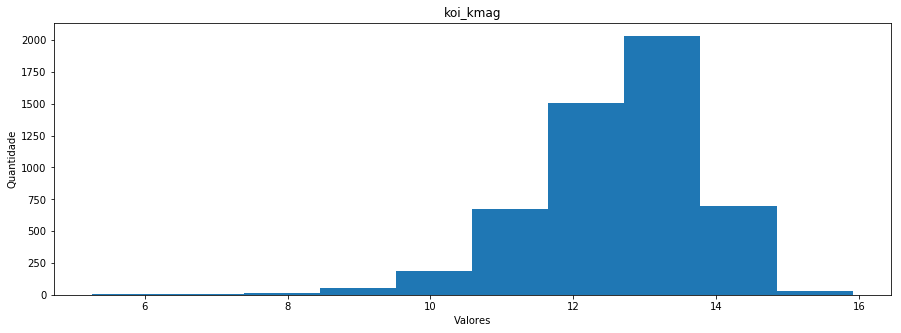

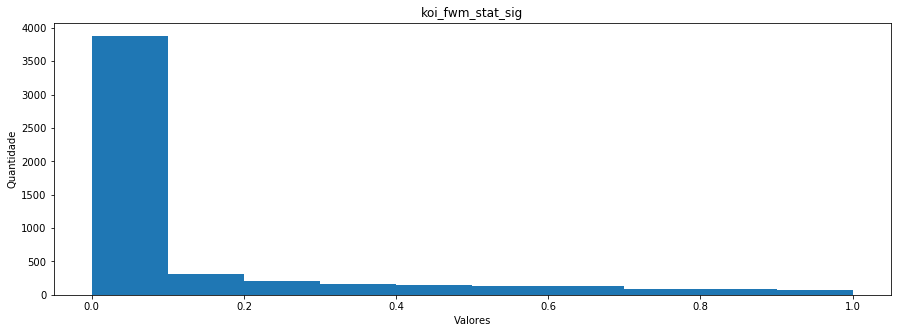

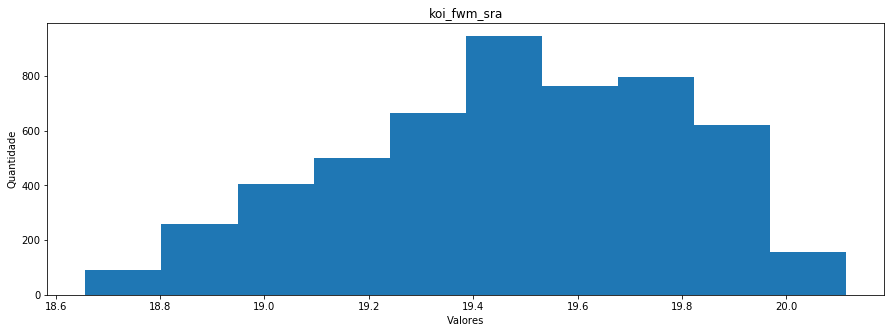

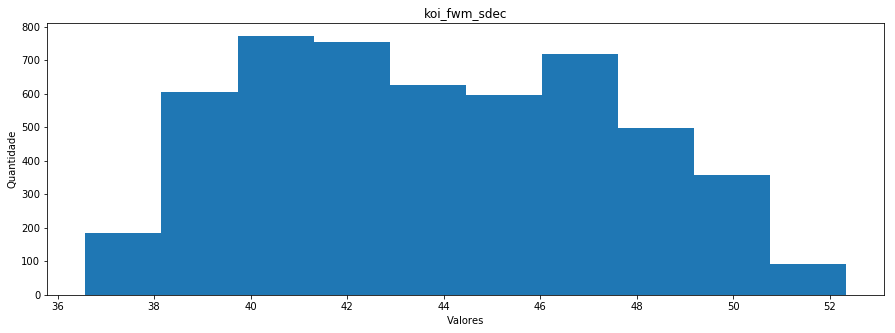

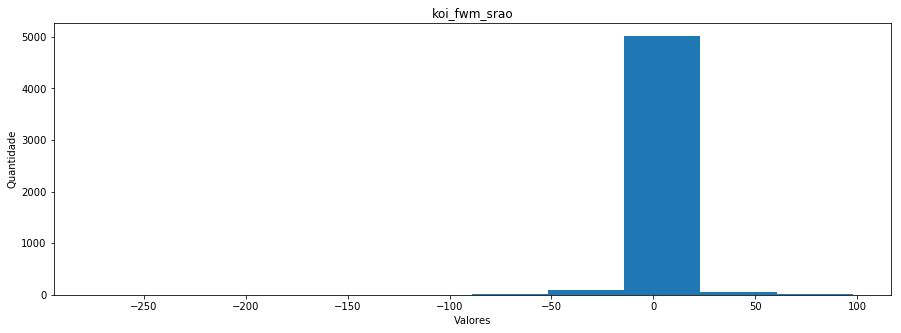

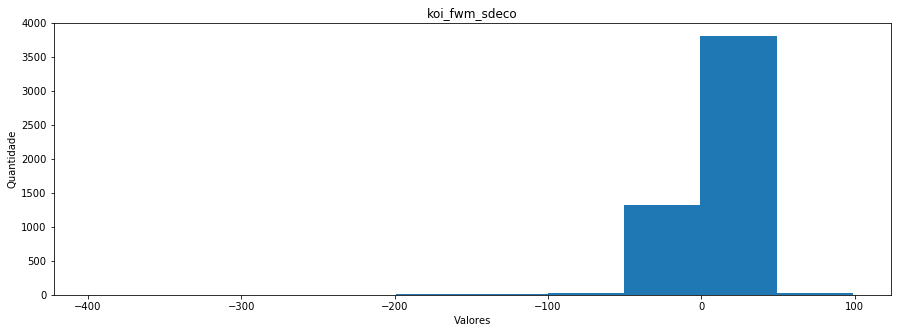

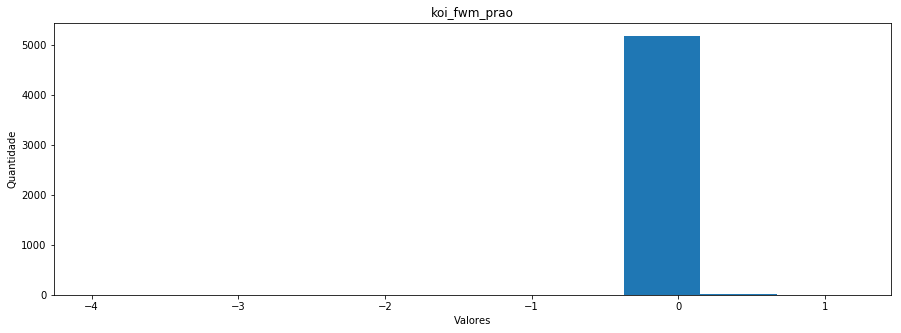

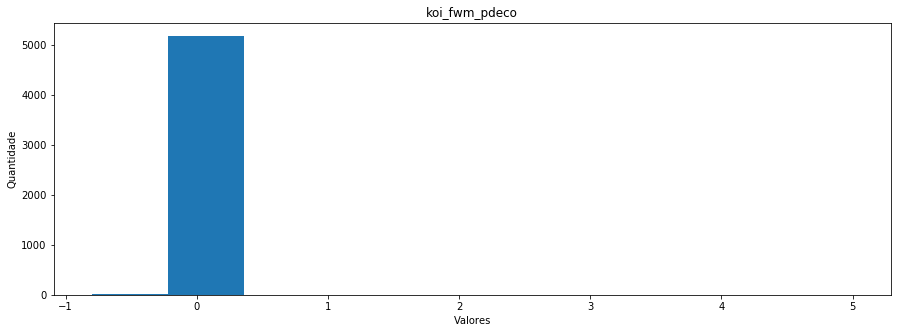

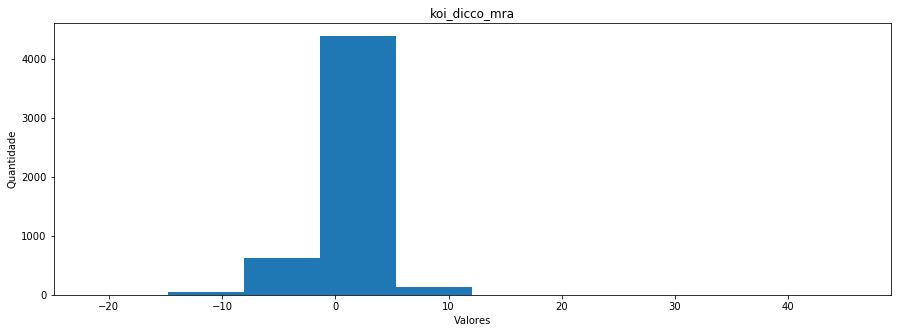

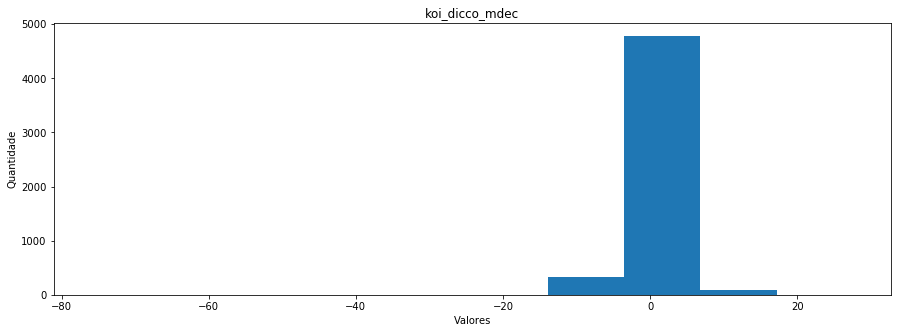

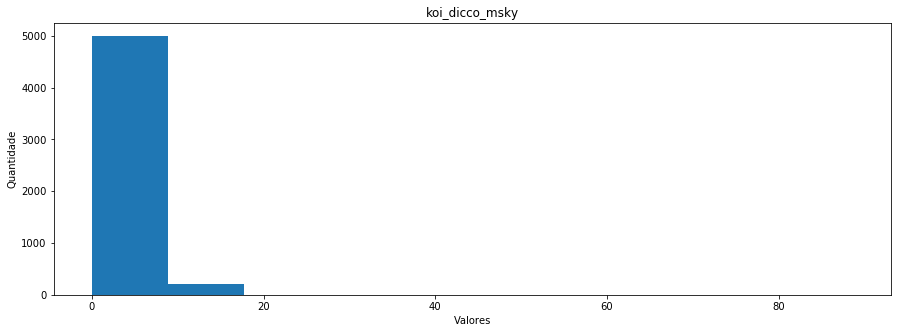

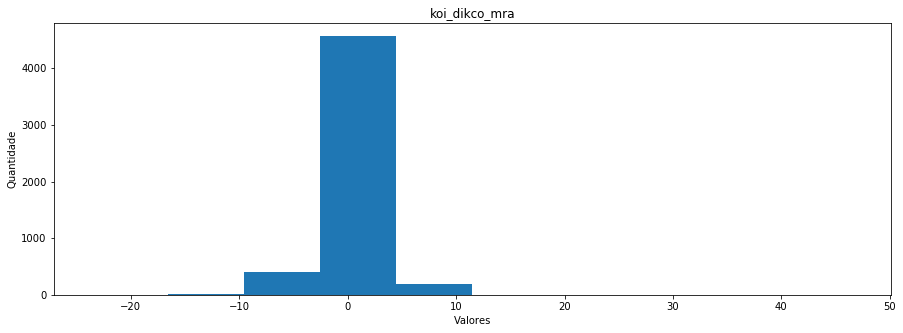

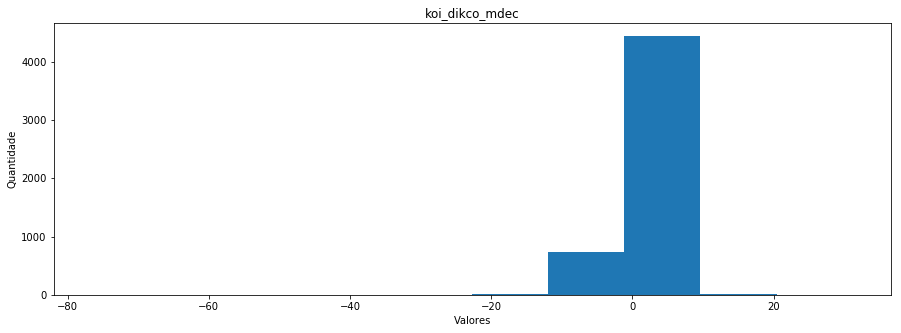

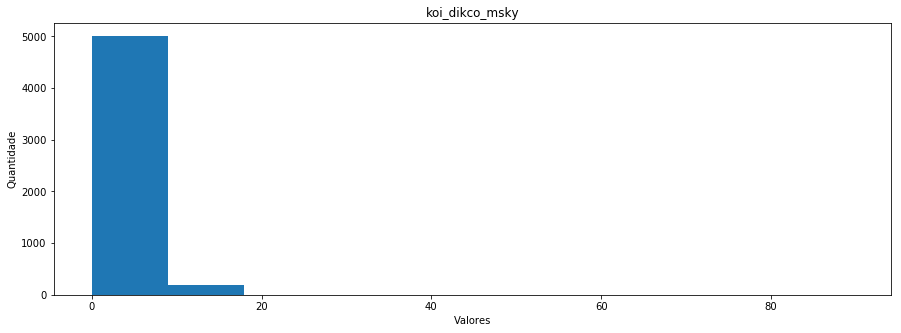

In [5]:
print('Features:')

for f in features:
    plt.figure(figsize=(15, 5))
    plt.hist(data[f])
    plt.title(f)
    plt.xlabel('Valores')
    plt.ylabel('Quantidade')

    plt.show()

### Normalização
Não há dados com o desvio padrão próximo de zero, portanto é seguro subtrair a média e
dividir pelo desvio padrão.  
Além disso, não há dados faltantes, portanto não é necessário o tratamento deste tipo de
anomalia.

In [6]:
print(
  'Colunas com desvio padrão próximo de zero: ',
  data[features]
    .std()
    .apply(lambda x: math.isclose(x, 0))
    .sum()
)

data[features] = data[features] - data[features].mean()

data[features] = data[features] / data[features].std()

Colunas com desvio padrão próximo de zero:  0


## Definição da validação
Para a validação, utilizaremos validação cruzada *k-fold* com k igual 5.  
Além disso, analisaremos os resultados da validação cruzada com as métricas de precisão,
revocação e *f1*.  
Consideraremos a métrica *f1* como decisiva, pois ela é uma média
harmônica da precisão e revocação.

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

N_FOLDS = 5

kfold = KFold(n_splits = N_FOLDS)

phases = {
  'Train': lambda score: score.train, # get train score
  'Test': lambda score: score.test   # get test score
}

def cross_validate(alg):
  scores = {
    metric: Object(
      function = function,
      train = [],
      test = []
    )
    for metric, function in {
      'accuracy': accuracy_score,
      'precision': precision_score,
      'recall': recall_score,
      'f1': f1_score,
    }.items()
  }

  for train, test in kfold.split(data):
    train = data.iloc[train]
    test  = data.iloc[test]

    model = alg.fit(train[features], train[target])

    prediction = Object(
      train = model.predict(train[features]),
      test  = model.predict(test[features])
    )

    for score in scores.values():
      score.train.append(
        score.function(train[target], prediction.train)
      )
      score.test.append(
        score.function(test[target], prediction.test)
      )

  for score in scores.values():
    score.train = np.mean(score.train)
    score.test  = np.mean(score.test)

  return scores

### Funções para visualização dos resultados

In [8]:
def print_scores(scores):
  for phase, result in phases.items():
    print(phase + ':')
    for name, score in scores.items():
      print('  {}: {:.3f}'.format(name, result(score)))

In [9]:
def plot_scores(
  scores,
  title = None,
  xlabel = None,
  ylabel = None,
  xticks = None,
  yticks = None,
  ruler = None
):
  for curve in list(next(iter(scores.values()))):
    for phase, result in phases.items():
      x, y = zip(
        *sorted(
          (i, result(score[curve]))
          for i, score in scores.items()
        )
      )
      plt.plot(x, y, label = phase)

    if ruler and curve in ruler:
      plt.hlines(ruler[curve], min(x), max(x), linestyles = 'dashed')

    plt.title(title + ' - ' + curve)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks:
      plt.xticks(*xticks(x))
    if yticks:
      plt.yticks(*yticks(y))
    plt.legend()

    plt.show()

In [25]:
def plot_scores_bars(
  scores,
  title = None,
  xlabel = None,
  ylabel = None,
  yticks = None,
  ylim = None,
  legend = None,
  ruler = None
):
  xticks = np.arange(len(scores))
  width = 0.1

  bars = list(next(iter(scores.values())))

  for phase, result in phases.items():
    for i, bar in enumerate(bars):
      plt.bar(
        xticks + i * width,
        [
          result(scores[j][bar])
          for j in scores
        ],
        width = width,
        label = bar
      )
    
    if ruler and phase == ruler.phase:
      plt.hlines(*ruler.line, linestyles = 'dashed')

    plt.title('{} - {}'.format(title, phase))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if yticks is not None:
      plt.yticks(yticks)
    plt.xticks([ r + 0.15 for r in xticks ], scores)
    if ylim:
      plt.ylim(ylim)
    plt.legend(loc = legend)

    plt.show()

## Modelos

In [11]:
models = {}

### Naive Bayes
Como *baseline*, utilizaremos o Naive Bayes com curva gaussiana.

In [30]:
from sklearn.naive_bayes import GaussianNB

gnb = Object(
  scores = cross_validate(GaussianNB())
)

print_scores(gnb.scores)

Train:
  accuracy: 0.917
  precision: 0.979
  recall: 0.879
  f1: 0.926
Test:
  accuracy: 0.916
  precision: 0.956
  recall: 0.882
  f1: 0.917


Sendo a métrica *f1* decisiva, teremos interesse nos modelos que apresentarem um
*score f1* superior a 0.917.

In [13]:
ruler = gnb.scores['f1'].test

### Decision Tree
Nas árvores de decisão, a altura é diretamente proporcional à complexidade do modelo.
Portanto, quanto mais alta a árvore, mais *overfitting* ocorre, o que pode ser observado
ao variar este híper-parâmetro.

In [14]:
from sklearn.tree import DecisionTreeClassifier

models['Decision Tree'] = dtc = {
  i or len(heights): cross_validate(algorithm)
  for heights in [ [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None ] ]
  for i in heights
  for algorithm in [ DecisionTreeClassifier(max_depth = i) ]
}

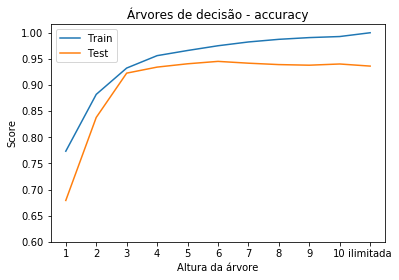

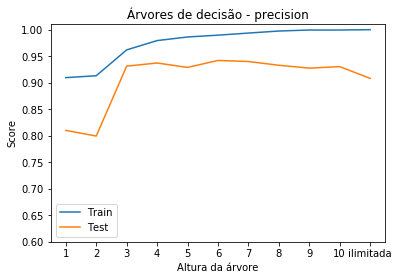

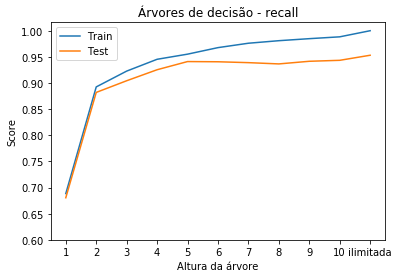

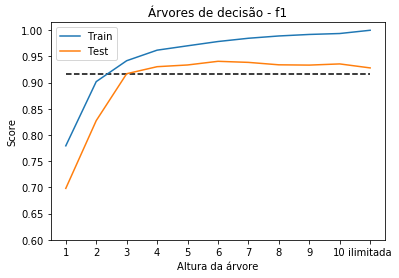

In [15]:
plot_scores(
  dtc,
  'Árvores de decisão',
  'Altura da árvore',
  'Score',
  lambda x: (x, [ str(i) for i in x[:-1] ] + ['ilimitada']),
  lambda y: (np.arange(0.6, 1.05, 0.05),),
  ruler = { 'f1': ruler }
)

Nas curvas das métricas acima, o *score* de treino se aproxima de 1 com alturas maiores,
enquanto o *score* de teste entra em decrescimento, o que é um indício claro de
*overfitting*.  
Na curva *f1*, nota-se que a altura com maior *score* de teste é 6, e após esta, o modelo
cai em *overfitting*. Ainda, a partir da altura 3, obtemos um *score* superior ao do
Naive Bayes.

### SVM
No SVM, o kernel permite mapear as amostras para um espaço de dimensão superior.  
A forma como as amostras são mapeadas no espaço influencia diretamente as possibilidades de
separação. Em especial, para o SVM, novas separações lineares podem surgir. Portanto, a
alteração do kernel pode causar grande impacto nos resultados.

In [16]:
from sklearn.svm import SVC

models['SVM'] = svm = {
  kernel: cross_validate(algorithm) 
  for kernel in [ 'linear', 'sigmoid', 'poly', 'rbf' ]
  for algorithm in [ SVC(kernel = kernel, gamma = 'auto') ]
}

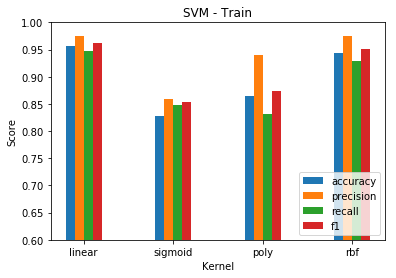

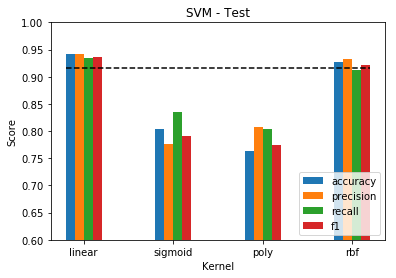

In [27]:
plot_scores_bars(
  svm,
  'SVM',
  'Kernel',
  'Score',
  legend = 'lower right',
  yticks = np.arange(0.5, 1.05, 0.05),
  ylim = (0.6, 1.0),
  ruler = Object(
    phase = 'Test',
    line = (ruler, -0.05, 3.35)
  )
)

O kernel **linear** obteve os melhores resultados em todas as métricas, logo à frente do
kernel **rbf**.  
Já os demais, obtiveram *scores* bem inferiores, piores até que o Naive Bayes,
provavelmente pois o mapeamento dos pontos não resultou em uma boa disposição para uma
separação linear.

### kNN
No k-NN, um menor número de vizinhos incorre em *overfitting*, pois o algorítmo irá se
adaptar a conjuntos mais concentrados da amostra. Observaremos os resultados variando este
parâmetro.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

models['k-NN'] = knn = {
  n: cross_validate(algorithm)
  for n in range(1, 31, 5)
  for algorithm in [ KNeighborsClassifier(n_neighbors = n) ]
}

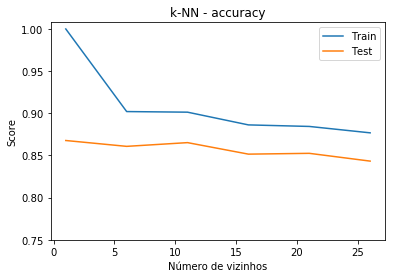

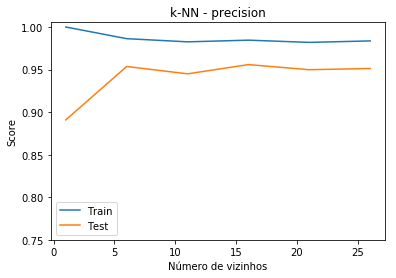

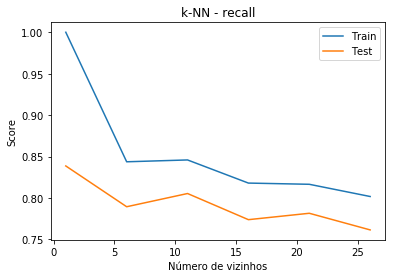

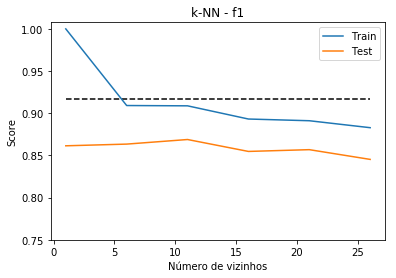

In [19]:
plot_scores(
  knn,
  'k-NN',
  'Número de vizinhos',
  'Score',
  yticks = lambda y: (np.arange(0.75, 1.01, 0.05),),
  ruler = { 'f1': ruler }
)

Nas métricas, observa-se que um pequeno número de vizinhos resulta em *overfitting*.  
Ainda, observamos que o algorítmo obteve um *score* bem abaixo dos competidores. Isto é
um indício de que as classes dos dados não são definidas pela proximidade espacial na
representação que utilizamos.

### Random Forest
Na Random Forest, as árvores são treinadas de forma a serem não correlacionadas,
utilizando as técnicas de *bootstrap sampling* e *random projection*. Desta forma, o
modelo previne o *overfitting* recorrente em árvores de decisão. Para atestar essa
propriedade, vamos variar o número de árvores na floresta, e observar os resultados.

In [48]:
from sklearn.ensemble import RandomForestClassifier

models['Random Forest'] = rfc = {
  n: cross_validate(algorithm)
  for n in range(2, 20, 2)
  for algorithm in [ RandomForestClassifier(n_estimators = n) ]
}

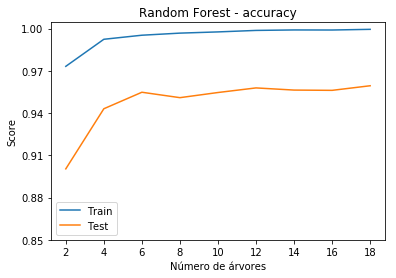

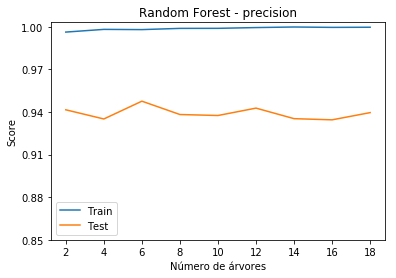

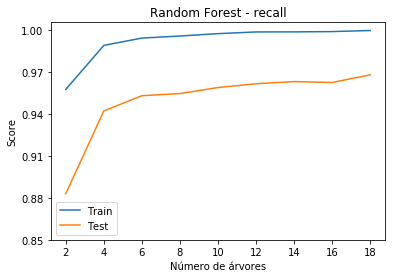

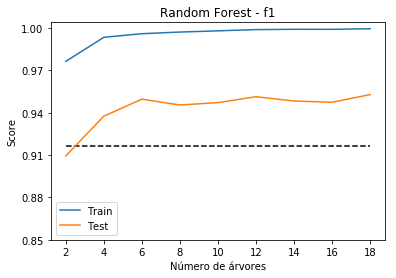

In [49]:
plot_scores(
  rfc,
  'Random Forest',
  'Número de árvores',
  'Score',
  yticks = lambda y: (np.arange(0.85, 1.01, 0.03),),
  ruler = { 'f1': ruler }
)

Mesmo com o crescente número de árvores, a distância entre o *score* de treino e o *score*
de teste não cresce, mesmo com o *score* de treino bem próximo de 1.  
Ainda, em comparação com o Naive Bayes, a Random Forest obteve *score* superior mesmo com
um número baixo de árvores.

### Gradient Tree Boosting
Bem como em qualquer algorítmo de *boosting*, o número de iterações influi diretamente
sobre a competência dos modelos de se complementarem. No Gradient Tree Boosting, iremos
variar o número de iterações para observar como a combinação dos modelos resulta em
melhores resultados.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

models['Gradient Tree Boosting'] = gtb = {
  n: cross_validate(algorithm)
  for n in range(1, 31, 2)
  for algorithm in [ GradientBoostingClassifier(n_estimators = n) ]
}

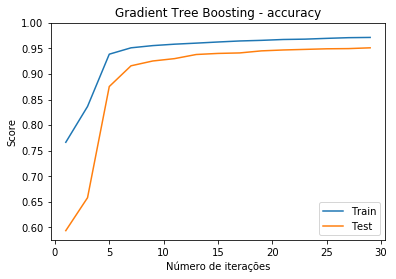

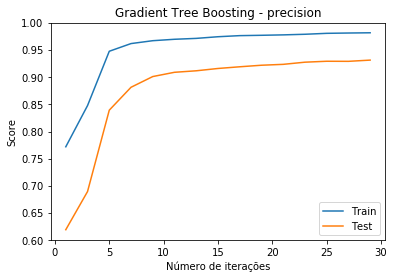

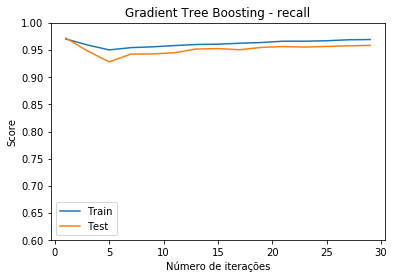

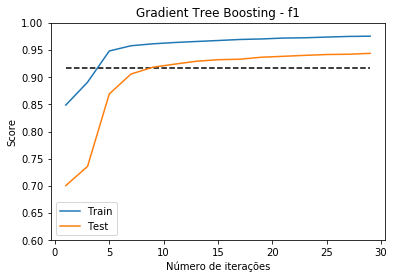

In [23]:
plot_scores(
  gtb,
  'Gradient Tree Boosting',
  'Número de iterações',
  'Score',
  yticks = lambda _: (np.arange(0.6, 1.05, 0.05),),
  ruler = { 'f1': ruler }
)

Como os modelos se complementam, algorítmos de *boosting* são menos propícios a
*overfitting*. Isso pode ser observado nas métricas acima, onde o *score* de teste não se
distancia do *score* de treino, mesmo com um alto número de iterações.
Ainda, na curva *f1*, nota-se que iterações maiores que 10 superam o *score* do Naive Bayes

# Conclusão
Com esse trabalho, concluí que as a performance dos modelos varia consideravelmente com o
caso de uso e a escolha dos híper-parâmetros. Selecionei o melhor *score f1* de cada modelo
no gráfico abaixo, de forma a observar qual se deu melhor para a classificação dos
exoplanetas.

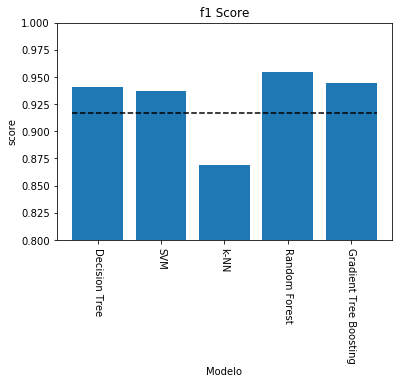

In [43]:
f1_scores = {
  name: max(
    score['f1'].test
    for score in model.values()
  )
  for name, model in models.items()
}

x = range(len(f1_scores))
y = f1_scores.values()

plt.bar(x, y, align = 'center')
plt.xticks(x, f1_scores, rotation = -90)
plt.ylim(0.8, 1)
plt.hlines(ruler, -0.4, 4.4, linestyles = 'dashed')

plt.title('f1 Score')
plt.xlabel('Modelo')
plt.ylabel('score')

plt.show()

Assim, conclui-se que o Random Forest obteve melhor performance para o problema.